In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
import shap
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


C:\Users\sanja\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/credit_card_transactions.csv")
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [3]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])


In [4]:
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
df['hour'] = df['trans_date_trans_time'].dt.hour
df['weekday'] = df['trans_date_trans_time'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['location_distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)
df['amount_log'] = np.log1p(df['amt'])
df['city_pop_log'] = np.log1p(df['city_pop'])


In [5]:
df['job'] = df['job'].astype('category').cat.codes
df['category'] = df['category'].astype('category').cat.codes
df['gender'] = df['gender'].map({'M': 0, 'F': 1})


In [6]:
features = ['amount_log', 'category', 'gender', 'city_pop_log', 'job', 'age',
            'hour', 'weekday', 'is_weekend', 'location_distance']
X = df[features]
y = df['is_fraud']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [8]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [9]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    scale_pos_weight=10,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_res, y_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
import os
os.makedirs("model", exist_ok=True)
xgb_model.save_model("model/xgb_model.json")
joblib.dump(features, "model/features.pkl")


['model/features.pkl']

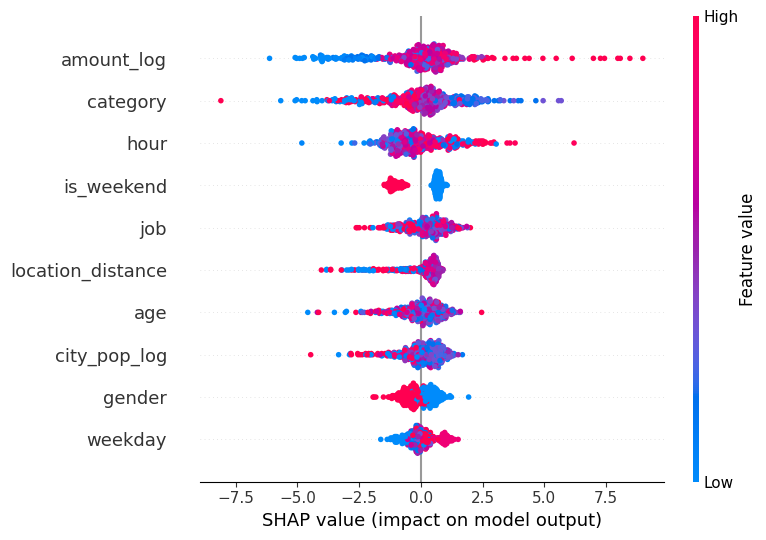

In [11]:
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test[:500])
shap.summary_plot(shap_values, X_test[:500], show=False)
plt.savefig("model/shap_summary.png")


In [12]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.9894683696031601
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    257834
           1       0.13      0.94      0.23      1501

    accuracy                           0.96    259335
   macro avg       0.57      0.95      0.61    259335
weighted avg       0.99      0.96      0.98    259335



In [13]:
df_results = X_test.copy()
df_results["Actual"] = y_test.values
df_results["Predicted"] = y_pred
df_results["Fraud Probability"] = y_proba
df_results.head(10)


,amount_log,category,gender,city_pop_log,job,age,hour,weekday,is_weekend,location_distance,Actual,Predicted,Fraud Probability
1161537,2.033398,8,1,7.554859,298,65,3,2,0,0.998005,0,0,0.004755
192923,4.246350,2,1,10.459755,218,47,11,1,0,0.893345,0,0,0.001489
1086283,4.819475,6,0,11.481878,228,55,17,4,0,0.887948,0,0,0.139457
1069482,4.540952,2,1,10.012611,458,81,6,4,0,1.179280,0,0,0.001110
689806,4.135327,4,1,8.601350,270,54,5,0,0,0.563819,0,0,0.028373
160555,1.893112,6,1,7.113956,113,28,23,0,0,1.057503,0,0,0.000012
1276446,4.569854,11,0,7.172425,120,43,10,6,1,0.509359,0,0,0.006067
508306,2.976549,12,0,8.948066,391,32,19,3,0,0.659422,0,0,0.134587
558111,4.096509,2,0,7.729735,128,75,0,0,0,0.688213,0,0,0.382483
1043182,1.278152,13,0,9.123256,292,56,22,6,1,0.614101,0,0,0.093753
